# Text Classification on Hacker News Data

Hacker News is a social news website focusing on computer science and entrepreneurship. It is run by Paul Graham's investment fund and startup incubator, Y Combinator. In general, content that can be submitted is defined as "anything that gratifies one's intellectual curiosity".  

This dataset contains all stories and comments from Hacker News from its launch in 2006. Each story contains a story id, the author that made the post, when it was written, and the number of points the story received.  
  
The dataset is publicly available on Google Cloud BigQuery in `bigquery-public-data` project. **We will look at the titles of articles and figure out whether the article came from the New York Times, TechCrunch or GitHub.**

## Data Preparation

In [90]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import sys
sys.path.append('./utils')

from common_functions import plot_curves

print(tf.__version__)

2.9.1


In [2]:
traindf = pd.read_csv('data/hackernews-train.csv')
evaldf = pd.read_csv('data/hackernews-eval.csv')

print(traindf.shape, evaldf.shape)

(72162, 2) (24041, 2)


In [3]:
print(traindf['source'].unique())
print(traindf.head(1))

['github' 'nytimes' 'techcrunch']
   source                                            title
0  github  this guy just found out how to bypass adblocker


In [4]:
CLASSES = {'github' : 0, 'nytimes' : 1, 'techcrunch' : 2}

traindf['source'] = traindf['source'].apply(lambda x: CLASSES[x])
evaldf['source'] = evaldf['source'].apply(lambda x: CLASSES[x])

print(traindf['source'].unique())

[0 1 2]


In [5]:
ytrain = keras.utils.to_categorical(traindf.pop('source').values)
yvalid = keras.utils.to_categorical(evaldf.pop('source').values)

print(ytrain[0])

[1. 0. 0.]


We want to use only TOP_K words for classification to keep only informative text and be memory-efficient still. `Tokenizer` would still build the word-index for all words, but will only TOP_K during transformations.

In [6]:
TOP_K = 30000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=TOP_K,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    analyzer=None,
)

texts = list(traindf['title'])
tokenizer.fit_on_texts(texts)
Xtrain = tokenizer.texts_to_sequences(texts)
Xvalid = tokenizer.texts_to_sequences(list(evaldf['title']))

assert len(Xtrain) == traindf.shape[0]

In [7]:
sample = texts[:1]
seq = tokenizer.texts_to_sequences(sample)
txt = tokenizer.sequences_to_texts(seq)

print(f"{txt}:{seq}")

['this guy just found out how to bypass adblocker']:[[103, 1549, 122, 646, 72, 26, 3, 3704, 20248]]


<AxesSubplot:>

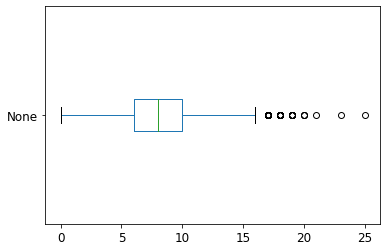

In [8]:
seq_len = pd.Series([len(x) for x in Xtrain])
seq_len.plot.box(vert=False)

In [9]:
MAX_LEN = 16

Xtrain = tf.keras.preprocessing.sequence.pad_sequences(
    sequences=Xtrain,
    maxlen=MAX_LEN,
    padding="pre",
    truncating="pre")

Xvalid = tf.keras.preprocessing.sequence.pad_sequences(
    sequences=Xvalid,
    maxlen=MAX_LEN,
    padding="pre",
    truncating="pre")

assert set([MAX_LEN]) == set([len(x) for x in Xtrain])

## Model

In [53]:
%%time
keras.backend.clear_session()

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(input_shape=(MAX_LEN,)))
model.add(keras.layers.Embedding(
    input_dim=TOP_K+1,
    output_dim=32,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
))
model.add(keras.layers.Conv1D(
    filters=5,
    kernel_size=5,
    strides=2,
    activation="relu"
))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(
    units=16,
    activation="relu",
    kernel_regularizer=keras.regularizers.l1(l=0.1)
))

model.add(keras.layers.Dense(
    units=len(CLASSES),
    activation="softmax"
))

model.output_shape

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.TruePositives(),
        keras.metrics.TrueNegatives(),
        keras.metrics.FalsePositives(),
        keras.metrics.FalseNegatives()]
)

history = model.fit(
    x=Xtrain,
    y=ytrain,
    batch_size=Xtrain.shape[0],
    epochs=30,
    verbose='auto',
    validation_data=(Xvalid, yvalid),
    shuffle=True,
)

model.summary()

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 9.6089 - accuracy: 0.3766 - true_positives: 0.0000e+00 - true_negatives: 144324.0000 - false_positives: 0.0000e+00 - false_negatives: 72162.0000 - val_loss: 9.5595 - val_accuracy: 0.3831 - val_true_positives: 0.0000e+00 - val_true_negatives: 48082.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 24041.0000
Epoch 2/30
1/1 [==============================] - 1s 946ms/step - loss: 9.5596 - accuracy: 0.3817 - true_positives: 0.0000e+00 - true_negatives: 144324.0000 - false_positives: 0.0000e+00 - false_negatives: 72162.0000 - val_loss: 9.5107 - val_accuracy: 0.3843 - val_true_positives: 0.0000e+00 - val_true_negatives: 48082.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 24041.0000
Epoch 3/30
1/1 [==============================] - 1s 902ms/step - loss: 9.5106 - accuracy: 0.3857 - true_positives: 0.0000e+00 - true_negatives: 144324.0000 - false_positives: 0.0000e+00 - false_negatives: 72162.0000 

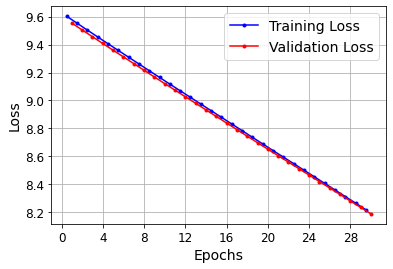

In [50]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

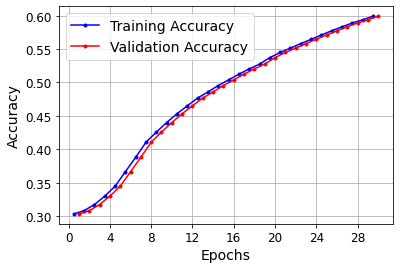

In [49]:
plot_curves(history.history['accuracy'],
            history.history['accuracy'],
            label='Accuracy')

In [116]:
from sklearn.metrics import classification_report

y_pred = model.predict(Xvalid)
one_hot_pred = keras.utils.to_categorical(np.argmax(y_pred, axis=1))
print(classification_report(yvalid, one_hot_pred))

752/752 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.41      0.98      0.58      9080
           1       0.44      0.00      0.01      7201
           2       0.73      0.20      0.32      7760

   micro avg       0.44      0.44      0.44     24041
   macro avg       0.52      0.40      0.30     24041
weighted avg       0.52      0.44      0.32     24041
 samples avg       0.44      0.44      0.44     24041



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=46e3e238-14db-4736-bba3-428176481d68' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>